## PHY 410
### GPS Final Project
### Jeremy Kazimer

***

### Import Statements

In [1]:
# Python libraries:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np

# Appending a path to get to utility files:
import sys
sys.path.append('utility')

# My utility libraries:
from get_data import *
from geographical_to_cartesian import *
from least_squares import *

### Experiments
##### Converting the data to a sensible form

We begin the experiments by first loading a random dataset from the set of four files I recorded on December 3rd, 2020:

In [2]:
# np.random.choice([1, 2, 3, 4]) picks an integer randomly from 1 - 4.
# .format() inserts that choice into the string at {}
filename = 'data/sample_{}.csv'.format(np.random.choice([1, 2, 3, 4, 5]))

print('working file: {}'.format(filename))

working file: data/sample_5.csv


Then, using my first helper library `get_data`, we load in the data in the form of a dictionary storing all the information that we care about:

In [3]:
position_dictionary = get_data(filename)

In [4]:
# Printing the keys, just to show what was stored:
print(position_dictionary.keys())

dict_keys(['time', 'latitude', 'longitude', 'altitude', 'z std', 'x & y std'])


Just to see the data in the geographical coordinate system, we can plot the main variables first as a function of time, then each other:

In [5]:
# Fetching the appropriate variables.
time = position_dictionary['time']

latitude = position_dictionary['latitude']
longitude = position_dictionary['longitude']
altitude = position_dictionary['altitude']

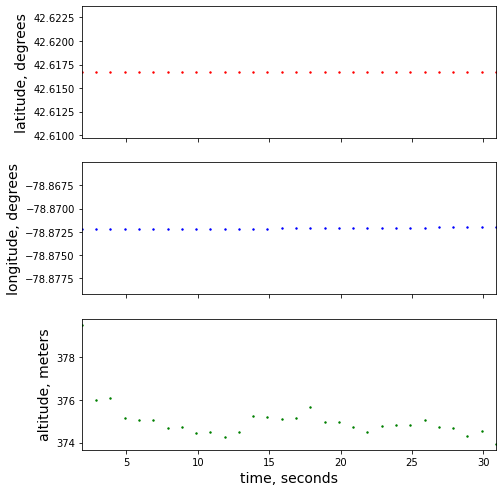

In [6]:
fig, axs = plt.subplots(3, 1, figsize = (7, 7), sharex = True)

# Plotting:
axs[0].scatter(time, latitude, s = 2, c = 'red')
axs[1].scatter(time, longitude, s = 2, c = 'blue')
axs[2].scatter(time, altitude, s = 2, c = 'green')

# Limiting x-axis:
axs[2].set_xlim(time[0], time[-1])

# Labels:
axs[0].set_ylabel('latitude, degrees', fontsize = 14)
axs[1].set_ylabel('longitude, degrees', fontsize = 14)
axs[2].set_ylabel('altitude, meters', fontsize = 14)

axs[2].set_xlabel('time, seconds', fontsize = 14)

fig.tight_layout()

fig.savefig('figures/2d_geographical_plot.pdf')

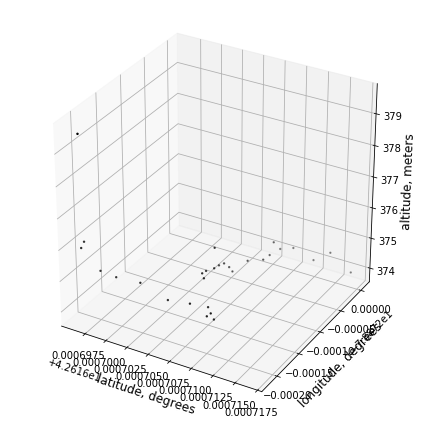

In [7]:
# Now, a 3D plot:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting:
ax.scatter(latitude, longitude, altitude, s = 2, c = 'k')

# Labels:
ax.set_xlabel('latitude, degrees', fontsize = 12)
ax.set_ylabel('longitude, degrees', fontsize = 12)
ax.set_zlabel('altitude, meters', fontsize = 12)

fig.tight_layout()

fig.savefig('figures/3d_geographical_plot.pdf')

# Sorry for the "longitude" label.  I couldn't seem to move it.

This plot is fine and all, but, aforementioned, it means nothing to the average person for two reasons.  First, that it's in an unconventional coordinate system for everyday use.  We can address this by converting the system to Cartesian.  For this, we'll use the `geographical_to_cartesian` library (see *Theory* for explanation):

In [8]:
cartesian_system = convert_coordinates(latitude, longitude, altitude)

In [9]:
# Once again, printing the keys for convenience.
print(cartesian_system.keys())

dict_keys(['x', 'y', 'z'])


In [10]:
x, y, z = cartesian_system['x'], cartesian_system['y'], cartesian_system['z']

We can now repeat the same plots above, but for the new coordinate system:

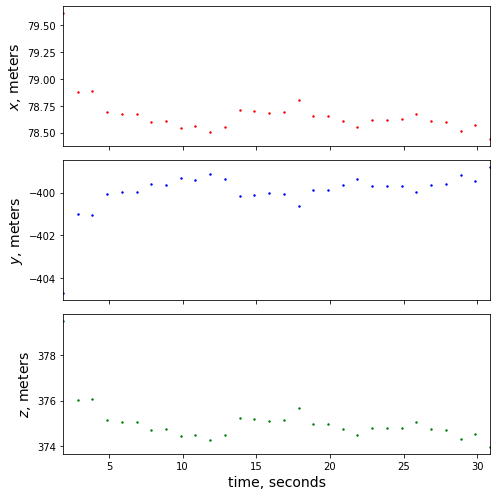

In [11]:
fig, axs = plt.subplots(3, 1, figsize = (7, 7), sharex = True)

# Plotting:
axs[0].scatter(time, x, s = 2, c = 'red')
axs[1].scatter(time, y, s = 2, c = 'blue')
axs[2].scatter(time, z, s = 2, c = 'green')

# Limiting x-axis:
axs[2].set_xlim(time[0], time[-1])

# Labels:
axs[0].set_ylabel('$x$, meters', fontsize = 14)
axs[1].set_ylabel('$y$, meters', fontsize = 14)
axs[2].set_ylabel('$z$, meters', fontsize = 14)

axs[2].set_xlabel('time, seconds', fontsize = 14)

fig.tight_layout()

fig.savefig('figures/2d_cartesian_plot.pdf')

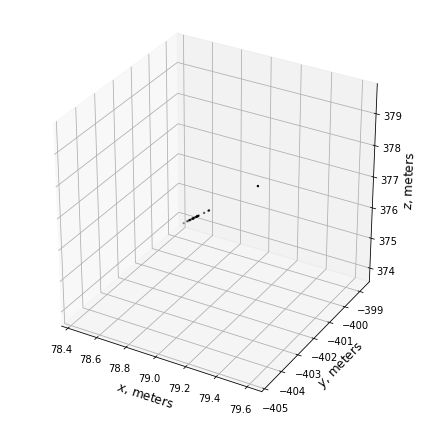

In [12]:
# Now, a 3D plot:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting:
ax.scatter(x, y, z, s = 2, c = 'k')

# Labels:
ax.set_xlabel('$x$, meters', fontsize = 12)
ax.set_ylabel('$y$, meters', fontsize = 12)
ax.set_zlabel('$z$, meters', fontsize = 12)

fig.tight_layout()

fig.savefig('figures/3d_cartesian_plot.pdf')

This is fine.  With a little more knowledge, the user can understand that they're moving away from their starting point.  However, my second concern arises:  although it's fine that the origin is not defined by the starting point, it doesn't make much sense to not shift the data to the starting point.

To me, this is because shifting to the origin tells the user a lot more information without additional thought.  For example, "you are 10 meters down from home" is more sensical than "you are at 250 meters in the $z$".  

As such, the conversion is generically $ds = s - s_0$, where $s$ is any generic position variable and $s_0$ is the first point in this set.  Then, $dn$ is simply the change in that variable at any given point.  In Python:

In [13]:
dx = x - x[0]
dy = y - y[0]
dz = z - z[0]

And a demonstrative plot:

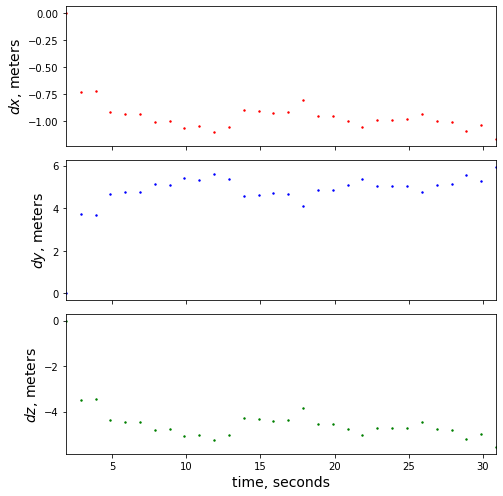

In [14]:
fig, axs = plt.subplots(3, 1, figsize = (7, 7), sharex = True)

# Plotting:
axs[0].scatter(time, dx, s = 2, c = 'red')
axs[1].scatter(time, dy, s = 2, c = 'blue')
axs[2].scatter(time, dz, s = 2, c = 'green')

# Limiting x-axis:
axs[2].set_xlim(time[0], time[-1])

# Labels:
axs[0].set_ylabel('$dx$, meters', fontsize = 14)
axs[1].set_ylabel('$dy$, meters', fontsize = 14)
axs[2].set_ylabel('$dz$, meters', fontsize = 14)

axs[2].set_xlabel('time, seconds', fontsize = 14)

fig.tight_layout()

fig.savefig('figures/2d_relative_cartesian_plot.pdf')

For $dx$, consider that my driveway is straight east, so effectively the value should be $0$, but fluctuations occur due to standard error as well as maybe me walking incorrectly at points.

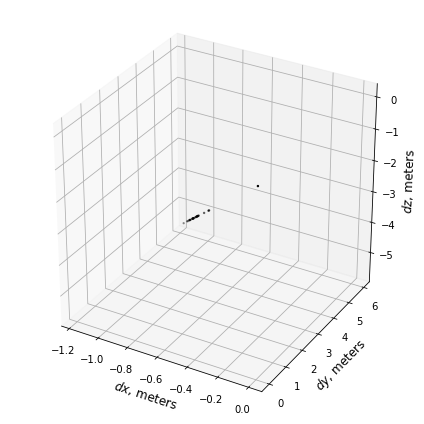

In [15]:
# Now, a 3D plot:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting:
ax.scatter(dx, dy, dz, s = 2, c = 'k')

# Labels:
ax.set_xlabel('$dx$, meters', fontsize = 12)
ax.set_ylabel('$dy$, meters', fontsize = 12)
ax.set_zlabel('$dz$, meters', fontsize = 12)

fig.tight_layout()

fig.savefig('figures/3d_relative_cartesian_plot.pdf')

As suggested, the structure of the data doesn't really change that much (see _Theory_ for more).  To me, this is more interpretable for the average person.  Of course, it's unrealistic that the average person will see this, but it's far more reasonable to cater to the average than to the deviations.

The ultimate problem with this data, however, is the lack of data points; we could take a very long walk, but then we would face the same issue.  It's best to attempt to recreate the same walk, with the same initial conditions and length, and then merge the data such that we have a denser distribution in a shorter span of time.

##### Merging the data

Rather than taking a random subset of the data, we can instead look at all the releveant data and combine it.  This is rather easy in Python:

In [16]:
# The list of data that is compatible
data = [1, 2, 3, 4, 5]

# It would be better to use, say, a numpy array
# of defined length but we won't have that much data.
x = np.array([]); y = np.array([]); z = np.array([])
std_x = np.array([]); std_y = np.array([]); std_z = np.array([])

time = np.array([]);
for datum in data:
    
    filename = 'data/sample_{}.csv'.format(datum)
    position_dictionary = get_data(filename)
    
    # Geographical position variables
    latitude = position_dictionary['latitude']
    longitude = position_dictionary['longitude']
    altitude = position_dictionary['altitude']

    cartesian_system = convert_coordinates(latitude, longitude, altitude)
    
    x = np.append(x, cartesian_system['x'])
    y = np.append(y, cartesian_system['y'])
    z = np.append(z, cartesian_system['z'])
    
    std_x = np.append(std_x, position_dictionary['x & y std'])
    std_y = np.append(std_y, position_dictionary['x & y std'])
    std_z = np.append(std_z, position_dictionary['z std'])
    
    time = np.append(time, position_dictionary['time'])

# Sort in case .plot is used, otherwise it'll look weird.
time_sort = np.argsort(time)
time = time[time_sort]

x = x[time_sort]; y = y[time_sort]; z = z[time_sort]
std_x = std_x[time_sort]; std_y = std_y[time_sort]; std_z = std_z[time_sort]

In [17]:
dx = x - x[0]
dy = y - y[0]
dz = z - z[0]
time = time - time[0]

We can now plot again, this time with the total data:

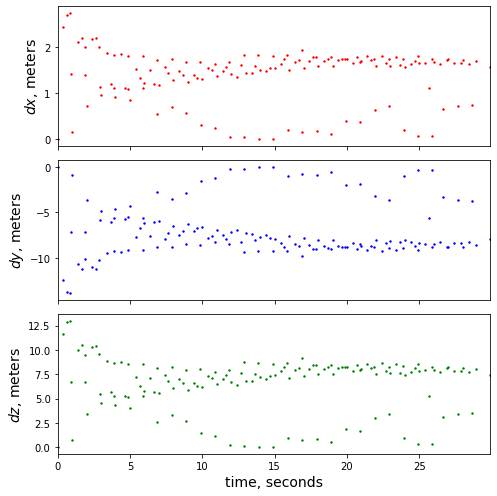

In [18]:
fig, axs = plt.subplots(3, 1, figsize = (7, 7), sharex = True)

# Plotting:
axs[0].scatter(time, dx, s = 2, c = 'red')
axs[1].scatter(time, dy, s = 2, c = 'blue')
axs[2].scatter(time, dz, s = 2, c = 'green')

# Limiting x-axis:
axs[2].set_xlim(time[0], time[-1])

# Labels:
axs[0].set_ylabel('$dx$, meters', fontsize = 14)
axs[1].set_ylabel('$dy$, meters', fontsize = 14)
axs[2].set_ylabel('$dz$, meters', fontsize = 14)

axs[2].set_xlabel('time, seconds', fontsize = 14)

fig.tight_layout()

fig.savefig('figures/2d_total_relative_cartesian_plot.pdf')

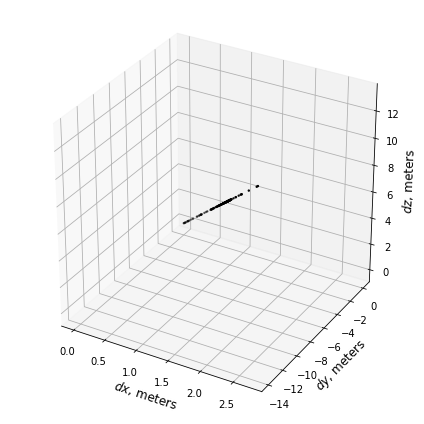

In [19]:
# Now, a 3D plot:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting:
ax.scatter(dx, dy, dz, s = 2, c = 'k')

# Labels:
ax.set_xlabel('$dx$, meters', fontsize = 12)
ax.set_ylabel('$dy$, meters', fontsize = 12)
ax.set_zlabel('$dz$, meters', fontsize = 12)

fig.tight_layout()

fig.savefig('figures/3d_total_relative_cartesian_plot.pdf')

The pure volume of plots may seem excessive, since they're effectively copies of each other.  However, I think it is important to show the transformations.  I also think that it's important to understand that a higher density of points it to our benefit, hence the last set of plots.

Consider that more points means that a lot of the statistical noise will start to dissolve such that a more accurate fit is formed.  Especially with something like `phyphox`, that at times cannot be trusted in their measurements.  

Regardless, we can now begin to fit the data:

##### Fitting the univariate data

The question then arises of how to fit the data.  First, it depends on what exactly is being predicted.  In the most basic case, $f(t)$ is a useful quantity to predict - it tells you where you should be as a function of time.  

Since time is purely linear (although this year has felt the opposite), we'll utilize least-squares (see `Theory`) to fit our model:

In [20]:
# By putting it in an array, we don't have to repeat code.
ds_array = [dx, dy, dz]

# As to more easily index.
std_array = [std_x, 
             std_y,
             std_z]

# 3 coefficients, 3 dimensions.
coefficients = np.zeros((3, 2))

for idx, ds in enumerate(ds_array):

    std_ds = std_array[idx]

    linear_coefficients = least_squares(ds, time, n = 1)
    
    coefficients[idx] = linear_coefficients

And now, a simple plot as demonstration:

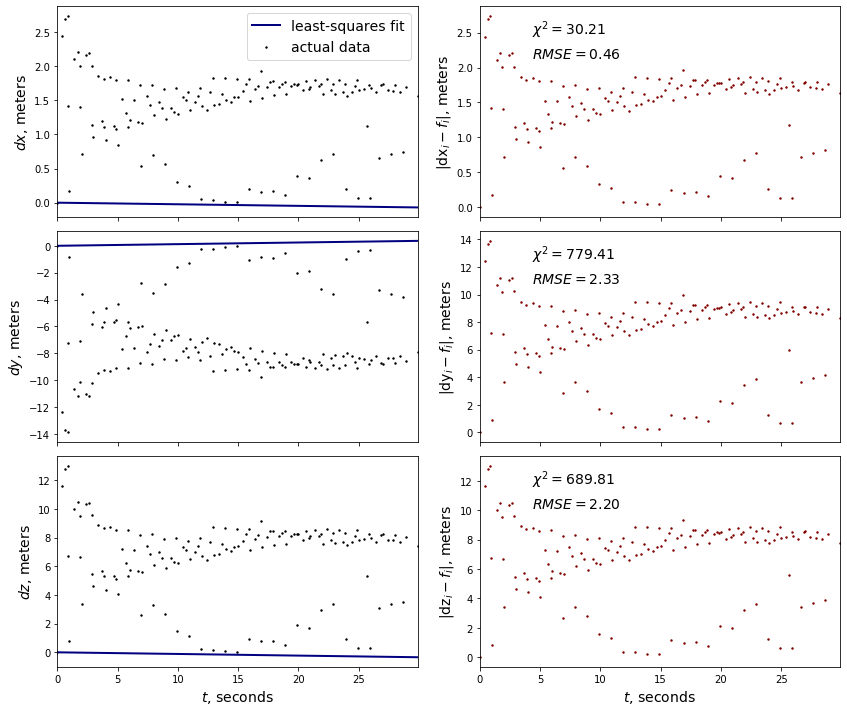

In [35]:
labels = [r'$dx$', r'$dy$', r'$dz$']

fig, axs = plt.subplots(3, 2, sharex = True, figsize = (12, 10))

for idx, label in enumerate(labels):
    
    # Pulling the prediction.  They stored in ascending power:
    coeff = coefficients[idx]
    fit = coeff[1]*time
    
    # First, the comparison of functions:
    axs[idx][0].scatter(time, ds_array[idx], s = 2, c = 'k', label = 'actual data')
    axs[idx][0].plot(time, fit, lw = 2, c = 'navy', label = 'least-squares fit')
    
    axs[idx][0].set_ylabel(label + ', meters', fontsize = 14)
    
    # Then the error:
    axs[idx][1].scatter(time, abs(ds_array[idx] - fit), c = 'maroon', s = 2)
    
    axs[idx][1].set_ylabel('$|{}_i - {}|$, meters'.format(label, 'f_i'), fontsize = 14)
    
    # Spoofing a legend to insert chi2:
    axs[idx][1].scatter(time[0], abs(ds_array[idx] - fit)[0],
                       s = 0,
                       label = r'$\chi^2 = {:.2f}$'.format(chi2(ds_array[idx], fit, std_array[idx])))
    
    axs[idx][1].scatter(time[0], abs(ds_array[idx] - fit)[0],
                       s = 0,
                       label = r'$RMSE = {:.2f}$'.format(rmse(ds_array[idx], fit, std_array[idx])))
    
    axs[idx][1].legend(loc = 'upper left', fontsize = 14, frameon = False)
    
    if idx == 2:
        axs[idx][0].set_xlabel('$t$, seconds', fontsize = 14)
        axs[idx][1].set_xlabel('$t$, seconds', fontsize = 14)
    
    axs[idx][0].set_xlim(time[0], time[-1])
    axs[idx][1].set_xlim(time[0], time[-1])
    
axs[0][0].legend(loc = 'upper right', fontsize = 14)
    
fig.tight_layout()

fig.savefig('figures/univariate_fit_plot.pdf')

Even for large enough data, we see that the fit is pretty bad.  The issue is that there exists too many outliers such that they cause the prediction to be negatively skewed, as evidenced by the scatterplot of high error.  Although there are plenty of dots tending towards zero, there are enough tending towards the max of the original data such that it shifts the results.  There also originally wasn't a trend in the time data, since position it related to time, but not necessarily time to position.  There is arguably no correlation unless higher motion is explored.

However, since this predicts a physical system, we can print the coefficients such that we know initial acceleration, velocity, etc.:

In [22]:
coeff_dx = coefficients[0]
labels = ['position', 'velocity']
units = ['m', 'm/s']

for idx, label in enumerate(labels):
    current_constant = 'initial {} in dx: {} {}'.format(label, coeff_dx[idx], units[idx])
    print(current_constant)

initial position in dx: 1.4178314462749535 m
initial velocity in dx: -0.002326265131394581 m/s


In [23]:
coeff_dy = coefficients[1]
labels = ['position', 'velocity']
units = ['m', 'm/s']

for idx, label in enumerate(labels):
    current_constant = 'initial {} in dy: {} {}'.format(label, coeff_dy[idx], units[idx])
    print(current_constant)

initial position in dy: -7.200237205416179 m
initial velocity in dy: 0.012234279859720249 m/s


In [24]:
coeff_dz = coefficients[2]
labels = ['position', 'velocity']
units = ['m', 'm/s']

for idx, label in enumerate(labels):
    current_constant = 'initial {} in dz: {} {}'.format(label, coeff_dz[idx], units[idx])
    print(current_constant)

initial position in dz: 6.7513395737400845 m
initial velocity in dz: -0.011469840237199005 m/s


Of course, initial position must be discarded since our system assumes $s_0 = 0$.  The only reason that it's not true here is because of the structure of the data.  With an infinite set of purely accurate points (i.e., $\sigma = 0$), then this would not be an issue.  But, alas, it is.  And it's the reason why the fit is so inaccurate.

##### Fitting the multivariate data

We can now repeat the process, but this time treating $r = f(x, y, z, t)$ such that we can fit the data according to the notion that $s = \dfrac{v_s}{v_q}q$, where $q$ is an orthogonal position vector (see `Theory`).  In code, we'll reject $c_0$ since we anticipate that it converges to zero:

In [25]:
pos_coefficients = np.zeros(3)

# Position coefficients
pos_coefficients[0] = least_squares(dx, dy, n = 1)[1]
pos_coefficients[1] = least_squares(dy, dx, n = 1)[1]
pos_coefficients[2] = least_squares(dz, dy, n = 1)[1]

In [38]:
print('proportion of velocities:')
print(pos_coefficients)

proportion of velocities:
[-0.19667606 -5.08449174 -0.93770121]


We can then plot the data to reflect these predictions:

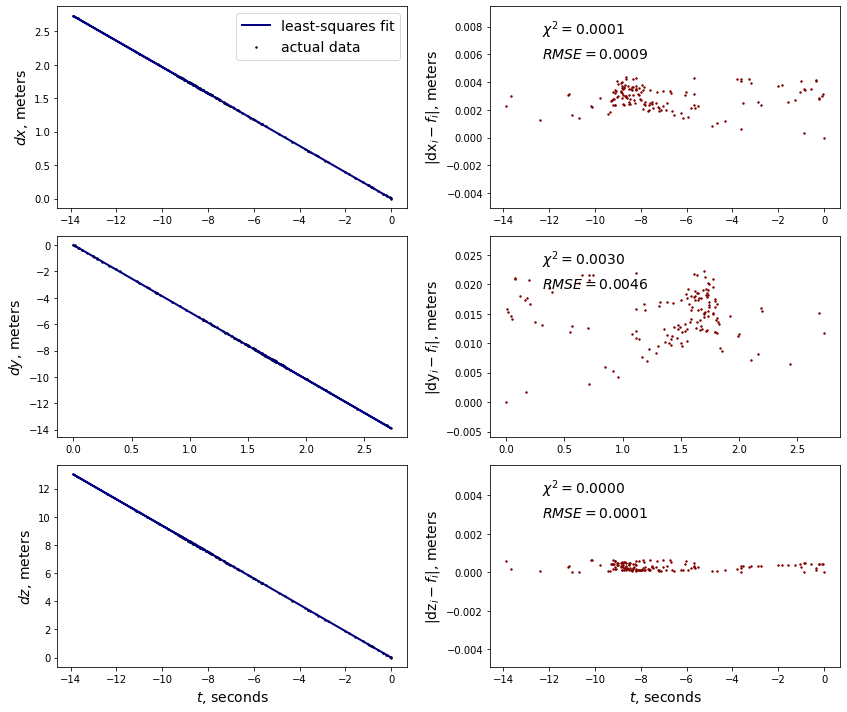

In [26]:
labels = [r'$dx$', r'$dy$', r'$dz$']
props = [(dx, dy), (dy, dx), (dz, dy)]

fig, axs = plt.subplots(3, 2, figsize = (12, 10))

for idx, label in enumerate(labels):
    
    # Pulling the prediction.  They stored in ascending power:
    coeff = pos_coefficients[idx]
    p, q = props[idx]
    
    fit = (coeff*q)
    
    # First, the comparison of functions:
    axs[idx][0].scatter(q, p, s = 2, c = 'k', label = 'actual data')
    axs[idx][0].plot(q, fit, lw = 2, c = 'navy', label = 'least-squares fit')
    
    axs[idx][0].set_ylabel(label + ', meters', fontsize = 14)
    
    # Then the error:
    axs[idx][1].scatter(q, abs(ds_array[idx] - fit), c = 'maroon', s = 2)
    
    axs[idx][1].set_ylabel('$|{}_i - {}|$, meters'.format(label, 'f_i'), fontsize = 14)
    
    # Spoofing a legend to insert chi2:
    axs[idx][1].scatter(q[0], abs(ds_array[idx] - fit)[0],
                       s = 0,
                       label = r'$\chi^2 = {:.4f}$'.format(chi2(ds_array[idx], fit, std_array[idx])))
    
    axs[idx][1].scatter(q[0], abs(ds_array[idx] - fit)[0],
                       s = 0,
                       label = r'$RMSE = {:.4f}$'.format(rmse(ds_array[idx], fit, std_array[idx])))
    
    axs[idx][1].legend(loc = 'upper left', fontsize = 14, frameon = False)
    
    if idx == 2:
        axs[idx][0].set_xlabel('$t$, seconds', fontsize = 14)
        axs[idx][1].set_xlabel('$t$, seconds', fontsize = 14)

    
    axs[0][0].legend(loc = 'upper right', fontsize = 14)
    
fig.tight_layout()

fig.savefig('figures/multivariate_fit_plot.pdf')

Thus, we see that the linear fit here performs much better than that of the time data.  Perhaps this is because these elements, $x$, $y$, and $z$, are all a part of the same vector, $r$.  So, it could potentially be reduced down knowing this information.  Regardless, the fit is better and more telling of the actual position data.  It certainly does help that they're functions of each other, as evidenced in `Theory`.

We can then take this a step further by ...